In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score
from torchvision import transforms
from astropy.io import fits 
from skimage.transform import resize
import time

import matplotlib
%matplotlib inline
#matplotlib.use('Agg')
from matplotlib import pyplot as plt

from weighting import weighting

torch.cuda.benchmark=True

In [2]:
class CategoricalNet(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(
            
            torch.nn.Conv2d(1,64,5,padding=2), # 1 input, 32 out, filter size = 5x5, 2 block outer padding
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,128,5,padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128,256,5,padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(2))
 
        self.classifier = torch.nn.Sequential(
		    torch.nn.Dropout(0.25),
            torch.nn.Linear(256*16*16,256), # Fully connected layer 
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(256,10))
        
    def forward(self,x):
        features = self.feature_extractor(x)
        output = self.classifier(features.view(int(x.size()[0]),-1))
        output= torch.nn.functional.log_softmax(output,dim=1)
        return output

In [3]:
class RegressionNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(128, 256, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(512, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(256, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.25),
            torch.nn.Linear(128 * 2 * 2, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(256, 10))

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features.view(int(x.size()[0]), -1))
        # output= F.log_softmax(output,dim=1) # Give results using softmax
        return output

In [4]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()

In [5]:
import torch.utils.data as data

IMG_EXTENSIONS = [
    ".fits"
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images


def default_fits_loader(file_name: str, img_size: tuple, slice_index):
    file = fits.open(file_name)
    _data = file[1].data
    _data = resize(_data[slice_index], img_size)
    _label = file[0].header['LABEL']

    if len(_data.shape) < 3:
        _data = _data.reshape((*_data.shape, 1))
    
    return _data, _label


class FITSCubeDataset(data.Dataset):
    def __init__(self, data_path, cube_length, transforms, img_size):
        self.data_path = data_path
        self.transforms = transforms
        self.img_size = img_size
        self.cube_length = cube_length
        self.img_files = make_dataset(data_path)

    def __getitem__(self, index):
        cube_index = index // self.cube_length
        slice_index = index % self.cube_length
        _img, _label = default_fits_loader(self.img_files[cube_index], self.img_size, slice_index)
        _img[_img != _img] = 0
        if self.transforms is not None:
            _data = (self.transforms(_img), _label)
        else:
            _data = (_img, _label)
            
        return _data

    def __len__(self):
        return len(self.img_files)*self.cube_length

In [6]:
IMG_PATH = "E:/Documents/Python_Scripts/CNN/TRAINING/"

def plot_accuracy(accuracies, val_acc, epochs, filename):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim(0, max(epochs))
    ax.set_ylim(0, 100)
    plt.plot(epochs, accuracies,'b',label='Training Accuracy',zorder=1)
    plt.plot(epochs, val_acc,'purple',label='Validation Accuracy',zorder=0)
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epoch')
    plt.legend(loc='best',fontsize='small')
    fig.savefig(IMG_PATH+filename, bbox_inches='tight')
    plt.close()

In [7]:
def adjust_learning_rate(optimizer, epoch, initial_lr, num_epochs):
    decay = initial_lr / num_epochs
    lr = initial_lr - decay*epoch
    print("Set LR to %f" % lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
def train(model: torch.nn.Module, 
          transforms, 
          data_path="E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/", 
          val_path="E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/",  
          num_epochs=50, 
          batch_size=32, 
          verbose=True,
          cube_length=640, img_size=(64, 64), 
          loss=torch.nn.CrossEntropyLoss(), 
          lr_schedule=True, initial_lr=1e-3, suffix=""):

    data_path = os.path.abspath(data_path)
    val_path = os.path.abspath(val_path)
	
    model = model.train()
    device = torch.device("cuda")
    model = model.to(device).to(torch.float)
    start = time.time()
    
    print('Creating sampling weight array')
    train_loader = DataLoader(FITSCubeDataset(data_path, cube_length, transforms, img_size), batch_size=batch_size, shuffle=False)
    dataiter = iter(train_loader)
    dummy_labels = []
    for idx, (batch, target) in enumerate(tqdm(train_loader)):
        dummy_labels.append(np.array(target.numpy()))
    dummy_labels = np.hstack(dummy_labels)
    print(len(dummy_labels))
    weights = weighting(dummy_labels)
    sampler = WeightedRandomSampler(weights, len(weights))
    end = time.time()
    print('Weights Created in %.2gs'%(end-start))
    #batch size was 10*640?
    start = time.time()
    val_loader = DataLoader(FITSCubeDataset(val_path, cube_length, transforms, img_size), batch_size=batch_size, shuffle=False)
    dataiter = iter(val_loader)
    dummy_val_labels = []
    for idx, (batch, target) in enumerate(tqdm(val_loader)):
        dummy_val_labels.append(np.array(target.numpy()))
    dummy_val_labels = np.hstack(dummy_val_labels)
    print(len(dummy_val_labels))
    val_weights = weighting(dummy_val_labels)
    val_sampler = WeightedRandomSampler(val_weights, len(val_weights))
    end = time.time()
    print('Validation weights Created in %.2gs'%(end-start))
    
    loader = DataLoader(FITSCubeDataset(data_path, cube_length, transforms, img_size), batch_size, shuffle=False, sampler=sampler)
    validation_loader = DataLoader(FITSCubeDataset(data_path, cube_length, transforms, img_size), batch_size, shuffle=False, sampler=val_sampler)    
    optim = torch.optim.Adam(model.parameters(), initial_lr)
	
    accuracies, val_accuracies, epochs = [0], [0], [0]
	
    for i in range(num_epochs):
        print("Epoch %d of %d" % (i+1, num_epochs))
        _accuracies = []
        _val_accuracies = []
        model.train(True)
        for idx, (batch, target) in enumerate(tqdm(loader)):
            batch = batch.to(device).to(torch.float)
            if isinstance(loss, torch.nn.CrossEntropyLoss):
                target = target.to(device).to(torch.long)
            else:
                target = target.to(device).to(torch.float)
            pred = model(batch)

            loss_value = loss(pred, target)

            optim.zero_grad()
            loss_value.backward()
            optim.step()

            pred_npy = pred.detach().cpu().numpy()
            target_npy = target.detach().cpu().numpy()

            if isinstance(loss, torch.nn.CrossEntropyLoss):
                pred_npy = np.argmax(pred_npy, axis=1) 
                
            ###Change the error metric here###

            pred_int = np.round(pred_npy).astype(np.uint8).reshape(-1)
            target_npy = target_npy.astype(np.uint8).reshape(-1)

            _accuracies.append(accuracy_score(target_npy, pred_int)*100)
            
        epochs.append(i+1)

        mean_accuracy = sum(_accuracies)/len(_accuracies)
        accuracies.append(mean_accuracy)

        print("Mean accuracy: %f" % mean_accuracy)
        
        model.train(False)

        for idx, (batch, target) in enumerate(tqdm(validation_loader)):
            batch = batch.to(device).to(torch.float)
            if isinstance(loss, torch.nn.CrossEntropyLoss):
                target = target.to(device).to(torch.long)
            else:
                target = target.to(device).to(torch.float)
            pred = model(batch)

            loss_value = loss(pred, target)

            pred_npy = pred.detach().cpu().numpy()
            target_npy = target.detach().cpu().numpy()

            if isinstance(loss, torch.nn.CrossEntropyLoss):
                pred_npy = np.argmax(pred_npy, axis=1) 
                
            ###Change the error metric here###

            pred_int = np.round(pred_npy).astype(np.uint8).reshape(-1)
            target_npy = target_npy.astype(np.uint8).reshape(-1)

            _val_accuracies.append(accuracy_score(target_npy, pred_int)*100)

        mean_accuracy = sum(_val_accuracies)/len(_val_accuracies)
        val_accuracies.append(mean_accuracy)
        if lr_schedule:
            plot_accuracy(accuracies,val_accuracies, epochs, "Validation_accuracy_scheduler%s.png" % suffix)
        else:
            plot_accuracy(accuracies,val_accuracies, epochs, "Validation_accuracy_no_scheduler%s.png" % suffix)
        print("Mean Validation accuracy: %f" % mean_accuracy)
    
        
        
        model.eval()


In [ ]:
if __name__ == '__main__':
    print("Creating Model and Initializing weights")
	
#    for model_class, loss_fn, suffix in zip([CategoricalNet, RegressionNet], [torch.nn.CrossEntropyLoss(), torch.nn.MSELoss()], ["_categorical", "_regression"]):
#        for schedule in [True, False]:
            
    model_class, loss_fn, suffix = CategoricalNet, torch.nn.CrossEntropyLoss(), "_categorical"
    schedule = True
    
    model = model_class()
    model.apply(weight_init)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0], [1])])

start = time.time()
train(model, transform, num_epochs=80, batch_size=64, lr_schedule=schedule, loss=loss_fn, suffix=suffix)
end = time.time()
print('TRAIN TIME:')
print('%.2gs'%(end-start))

Creating Model and Initializing weights
Creating sampling weight array


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


6400
Weights Created in 24s


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.95it/s]


6400
Validation weights Created in 20s
Epoch 1 of 80


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.56it/s]


Mean accuracy: 28.562500


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


Mean Validation accuracy: 43.187500
Epoch 2 of 80


 19%|███████████████▍                                                                 | 19/100 [00:07<00:31,  2.59it/s]

In [ ]:
torch.save(model, IMG_PATH+'CategoricalNet.pt')

In [18]:
tester = torch.load(IMG_PATH+'CategoricalNet.pt')


In [19]:
tester

CategoricalNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.25)
    (1): Linear(in_features=65536, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [20]:
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        print(m.weight.data)

tensor([[[[ 0.0485,  0.0210,  0.0071,  0.0149,  0.0189],
          [ 0.0016,  0.0047,  0.0351, -0.0256,  0.0143],
          [-0.0474, -0.0530, -0.0164,  0.0724,  0.0559],
          [-0.0463, -0.0020, -0.0336,  0.0372, -0.0209],
          [-0.0642, -0.0663, -0.0016,  0.0223,  0.0263]]],


        [[[-0.0430,  0.0117, -0.0537, -0.0378, -0.0619],
          [-0.0755, -0.0066,  0.0206, -0.0299, -0.0152],
          [ 0.0153,  0.0372, -0.0017,  0.0019, -0.0365],
          [-0.0354, -0.0227, -0.0531,  0.0273, -0.0357],
          [-0.0361,  0.0110, -0.0529,  0.0050, -0.0891]]],


        [[[ 0.0693,  0.0502,  0.0358, -0.0184, -0.0271],
          [ 0.0306, -0.0393, -0.0438,  0.0015, -0.0498],
          [ 0.0582, -0.0538,  0.0334, -0.0376, -0.0581],
          [-0.0395, -0.0039,  0.0359,  0.0016,  0.0119],
          [ 0.0423, -0.0520, -0.0347, -0.0429,  0.0040]]],


        ...,


        [[[ 0.0281, -0.0426,  0.0228, -0.0363,  0.0134],
          [ 0.0213,  0.0584, -0.0276,  0.0197, -0.0134],
    

          [ 2.0024e-02,  1.4764e-02, -4.1769e-03, -2.2131e-03, -1.0421e-02]]]], device='cuda:0')
tensor([[[[-5.4353e-03, -1.5906e-02,  7.4564e-03,  1.1119e-02, -3.6101e-04],
          [ 5.0557e-03,  2.3335e-02,  1.0685e-02, -9.6131e-03,  1.4660e-02],
          [ 2.2526e-03,  1.4747e-02,  2.1030e-02,  2.0333e-02, -4.1131e-03],
          [ 3.2861e-02,  1.2439e-02,  1.6916e-02,  1.1013e-02, -9.6955e-03],
          [ 3.0325e-02,  7.3760e-03, -3.3155e-03,  1.5832e-03,  1.0102e-02]],

         [[ 3.8366e-04, -1.2781e-02,  9.1483e-03,  1.0370e-02, -2.9060e-03],
          [ 1.3742e-02, -2.3595e-02, -2.1712e-02,  1.2305e-02,  2.0453e-02],
          [-1.7619e-02, -2.3025e-03, -1.0473e-02, -1.3155e-02, -2.8832e-02],
          [ 1.0453e-02, -1.7517e-02, -1.7179e-02,  6.6102e-03, -1.0142e-03],
          [-1.2567e-02, -4.1926e-03, -1.5318e-02,  1.8625e-02,  2.4709e-03]],

         [[-9.9848e-03,  2.1044e-02,  1.3052e-02,  3.6738e-04, -1.7953e-02],
          [ 8.0347e-03,  1.5918e-02, -2.4908e-03,  6

          [ 3.3844e-02, -1.2092e-02,  1.4596e-02,  1.3731e-02, -3.5445e-03]]]], device='cuda:0')


In [32]:
test = fits.open("E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/RefL0025N0376,28,12,0,296111.fits")

Filename: E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/RefL0025N0376,28,12,0,296111.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1                1 ImageHDU         8   (64, 64, 640)   float64   
5


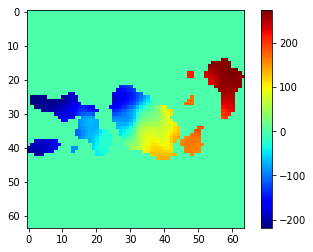

In [33]:
test.info()
print(test[0].header['LABEL'])
d = test[1].data[100]
d[d != d] = 0
plt.figure()
plt.imshow(d,cmap='jet')
plt.colorbar()
plt.show()

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0], [1])])
data = transform(d.reshape(*d.shape, 1)).unsqueeze(0).float().cuda()
print(data.shape)
output = torch.nn.functional.softmax(model(data),dim=1).cpu().detach().numpy()
print(output)
print(np.argmax(output))
test.close()

torch.Size([1, 1, 64, 64])
[[0.10421029 0.10504274 0.0921601  0.10288698 0.08882024 0.09020518
  0.11369208 0.10088989 0.11190583 0.09018672]]
6


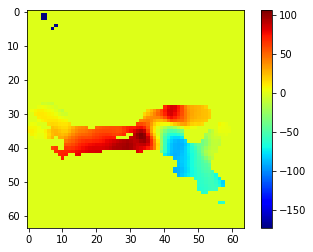

[[0.10421029 0.10504274 0.0921601  0.10288698 0.08882024 0.09020518
  0.11369208 0.10088989 0.11190583 0.09018672]]
6


In [40]:
test2 = fits.open("E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/RefL0100N1504,28,1222,0,9017403.fits")
d = test2[1].data[100]
d[d != d] = 0
plt.figure()
plt.imshow(d,cmap='jet')
plt.colorbar()
plt.show()
data = torch.from_numpy(d).unsqueeze(0).unsqueeze(0).float().cuda()
output = torch.nn.functional.softmax(model(data),dim=1).cpu().detach().numpy()
print(output)
print(np.argmax(output))